### Importing required libraries

In [1]:
%matplotlib inline

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
import scipy.stats as stats
from sklearn import cross_validation
from sklearn import linear_model



### Utilities

In [2]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    

### Importing data

In [2]:
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

In [3]:
# extended data set
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
data2 = sio.loadmat('rfMRI_REST1_HCP_S500.mat')
gF2 = np.ravel(data2['PMAT24_A_CR'])
data_ext = np.concatenate((data['rest_1_mat'],data2['rest_1_mat']),axis=2)
gF = np.concatenate((gF,gF2))
n_subj = len(gF)

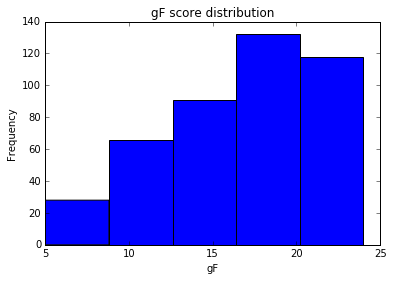

5

In [4]:
# gF score distribution 
n_bins = 5
def plot_hist(n_bins):
    plt.hist(gF, bins=n_bins)
    plt.title("gF score distribution")
    plt.xlabel("gF")
    plt.ylabel("Frequency")
    plt.show()
    return n_bins
    
interact(plot_hist, n_bins=(5,50,5)) 

# needed for stratified k-fold
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits)

### Building of input matrix
Starting from the connectivity matrices of each subject a #subjects x #edges matrix is built selecting for each subject the upper triangular matrix of the connectivity matrix (without the diagonal).

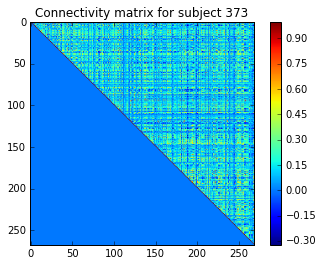

In [5]:
# choose dataset
#conn_mats = data['rest_1_mat']
conn_mats = data_ext

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]
    

### Test
Reproducing the work of [Finn et al](http://www.nature.com/neuro/journal/v18/n11/full/nn.4135.html), in a Leave-one-out cross validation (LOOCV) loop, only the edges with a significant correlation with the gF score (on training data) are selected and a statistic (network strengh) is computed on them; then  a first-degree polynomial is fit to model the relation between the statistic and the behavioural variable and it's used to predict the score on the test subject.
Two separate models are built for negatively and positively correlated edges.

In [129]:
# for each edge returns rho and p-value
pears = [stats.pearsonr(edges[:,i],gF) for i in range(0,n_edges)]
#pears = np.apply_along_axis(lambda row: stats.pearsonr(row,gF),0,edges)


In [ ]:


loo = cross_validation.LeaveOneOut(n_subj)
lr = linear_model.LinearRegression()
errors_pos = np.zeros([n_subj,1])
errors_neg = np.zeros([n_subj,1])
predictions_pos = np.zeros([n_subj,1])
predictions_neg = np.zeros([n_subj,1])

def regress(p,score,edges):
    i=0
    f = FloatProgress(min=0, max=n_subj)
    display(f)
    for train_index, test_index in loo:
        pears = [stats.pearsonr(edges[train_index,i],gF[train_index]) for i in range(0,n_edges)]
        # select edges (positively and negatively) correlated with gF with threshold p
        idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]>0])
        idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]<0])
        filtered_pos = edges[np.ix_(train_index,idx_filtered_pos)]
        filtered_neg = edges[np.ix_(train_index,idx_filtered_neg)]
        # compute network statistic for each subject in training
        strength_pos = filtered_pos.sum(axis=1) 
        strength_neg = filtered_neg.sum(axis=1)
        # compute network statistic for test subject
        str_pos_test = edges[test_index,idx_filtered_pos].sum()
        if(len(idx_filtered_neg)>0):
            str_neg_test = edges[test_index,idx_filtered_neg].sum()
        # regression
        lr_pos = lr.fit(strength_pos.reshape(-1,1),gF[train_index])
        predictions_pos[i] = lr_pos.predict(str_pos_test)
        errors_pos[i] = abs(predictions_pos[i]-gF[test_index])
        
        if(filtered_neg.shape[1]>0):
            lr_neg = lr.fit(strength_neg.reshape(-1,1),gF[train_index])
            predictions_neg[i] = lr_neg.predict(str_neg_test) 
            errors_neg[i] = abs(predictions_neg[i]-gF[test_index])
        else:
            errors_neg[i] = np.nan
            predictions_neg[i] = np.nan
        i=i+1
        f.value += 1
        
#interact(regress, p=(0.01,0.1,0.01),score=fixed(gF), edges=fixed(edges),continuous_update=False)
p=0.01
regress(p,gF,edges)



### Results

In [ ]:
results = {'finn_ext_preds_pos':predictions_pos, 'finn_ext_preds_neg':predictions_neg, 'finn_ext_errors_pos':errors_pos, 
           'finn_ext_errors_neg':errors_neg,'finn_ext_score':gF}
sio.savemat('res_finn_ext.mat',results)

In [69]:
print('Mean error positive model:',np.mean(errors_pos))
print('Mean error negative model:',np.mean(errors_neg))

print(predictions_pos.transpose())
print(predictions_neg.transpose())
print(gF)

Mean error positive model: 3.90614111792
Mean error negative model: 4.21983887943
[[ 15.25865234  15.51836177  16.17026192  17.31826583  15.2941144
   21.30627067  17.40853753  17.20996075  13.94748654  15.39868719
   14.83671538  17.65023444  16.90557682  14.81306977  16.03268131
   17.40635356  22.0832918   15.58642188  16.04727344  24.35935012
   20.17052055  17.96954829  18.35824078  21.57663824  16.98682956
   13.69765047  18.69491804  23.67140965  15.0144186   16.36417337
   17.90479743  16.22064948  14.7810428   15.63107604  14.88029288
   15.630403    19.08112285  14.63484139  16.25443349  17.67215078
   17.30756575  17.21486394  14.35859837  13.28985762  14.67116587
   16.11285959  16.17562677  16.36423366  21.39617015  16.59993226
   16.30068879  15.46410344  15.94725814  15.88296538  16.41778082
   18.89423877  16.85511133  15.72512529  16.3893343   13.38023327
   15.13410242  17.98883434  17.48555019  16.43983107  15.75267273
   16.39015861  15.61118445  13.39916182  17.595

In [ ]:
#preds_4[np.isnan(preds_4)] = 0
regression_plot(np.ravel(gF),np.ravel(preds_4),n_subj,'Random Forest - LOOCV- negative edges - PCA on training') 

Finn et al. obtained *r* = 0.5